# Importing Google Earth Engine satellite imagery into a Pandas dataframe

This was mostly copied from an amazing tutorial here:

https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair

And adapted to suit my needs for the Payette streamflow prediction project.

In [ ]:
import pandas as pd
import numpy as np

You must authenticate the Google Earth Engine access and initialize the API.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=p8Nx44Kog7jj9lzkEQ1GNWne4ceLTNXI09V19x9UX_Y&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4AH3mJWC64kQERjpVVuJMKHaZJFgTtbEupsYm4F5HFJaR_IuZRVysto

Successfully saved authorization token.


In [ ]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  Args:
    geometry:
      An ee.Geometry that defines the region over which to reduce data.
    reducer:
      Optional; An ee.Reducer that defines the reduction method.
    scale:
      Optional; A number that defines the nominal scale in meters of the
      projection to work in.
    crs:
      Optional; An ee.Projection or EPSG string ('EPSG:5070') that defines
      the projection to work in.
    bestEffort:
      Optional; A Boolean indicator for whether to use a larger scale if the
      geometry contains too many pixels at the given scale for the operation
      to succeed.
    maxPixels:
      Optional; A number specifying the maximum number of pixels to reduce.
    tileScale:
      Optional; A number representing the scaling factor used to reduce
      aggregation tile size; using a larger tileScale (e.g. 2 or 4) may enable
      computations that run out of memory with the default.

  Returns:
    A function that accepts an ee.Image and reduces it by region, according to
    the provided arguments.
  """

  def reduce_region_function(img):
    """Applies the ee.Image.reduceRegion() method.

    Args:
      img:
        An ee.Image to reduce to a statistic by region.

    Returns:
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

## Data Layer
The PDSI is the Palmer Drought Severity Index.
If you want a different metric, this is where to change it.

In [ ]:
pdsi = ee.ImageCollection('IDAHO_EPSCOR/PDSI')

## Area of interest
Change the area of interest by specifying the FeatureCollection and filtering it (In this case, we are looking at the Idaho Batholith ecoregion).

In future iterations, I would make the area of interest just the South Fork Payette watershed above Lowman.

In [ ]:
aoi = ee.FeatureCollection('EPA/Ecoregions/2013/L3').filter(
    ee.Filter.eq('na_l3name', 'Idaho Batholith')).geometry()

## Map of EPA Level 3 Ecoregions.
Number 16 in green is the Idaho Batholith Ecoregion, where the South Fork of the Payette is located.

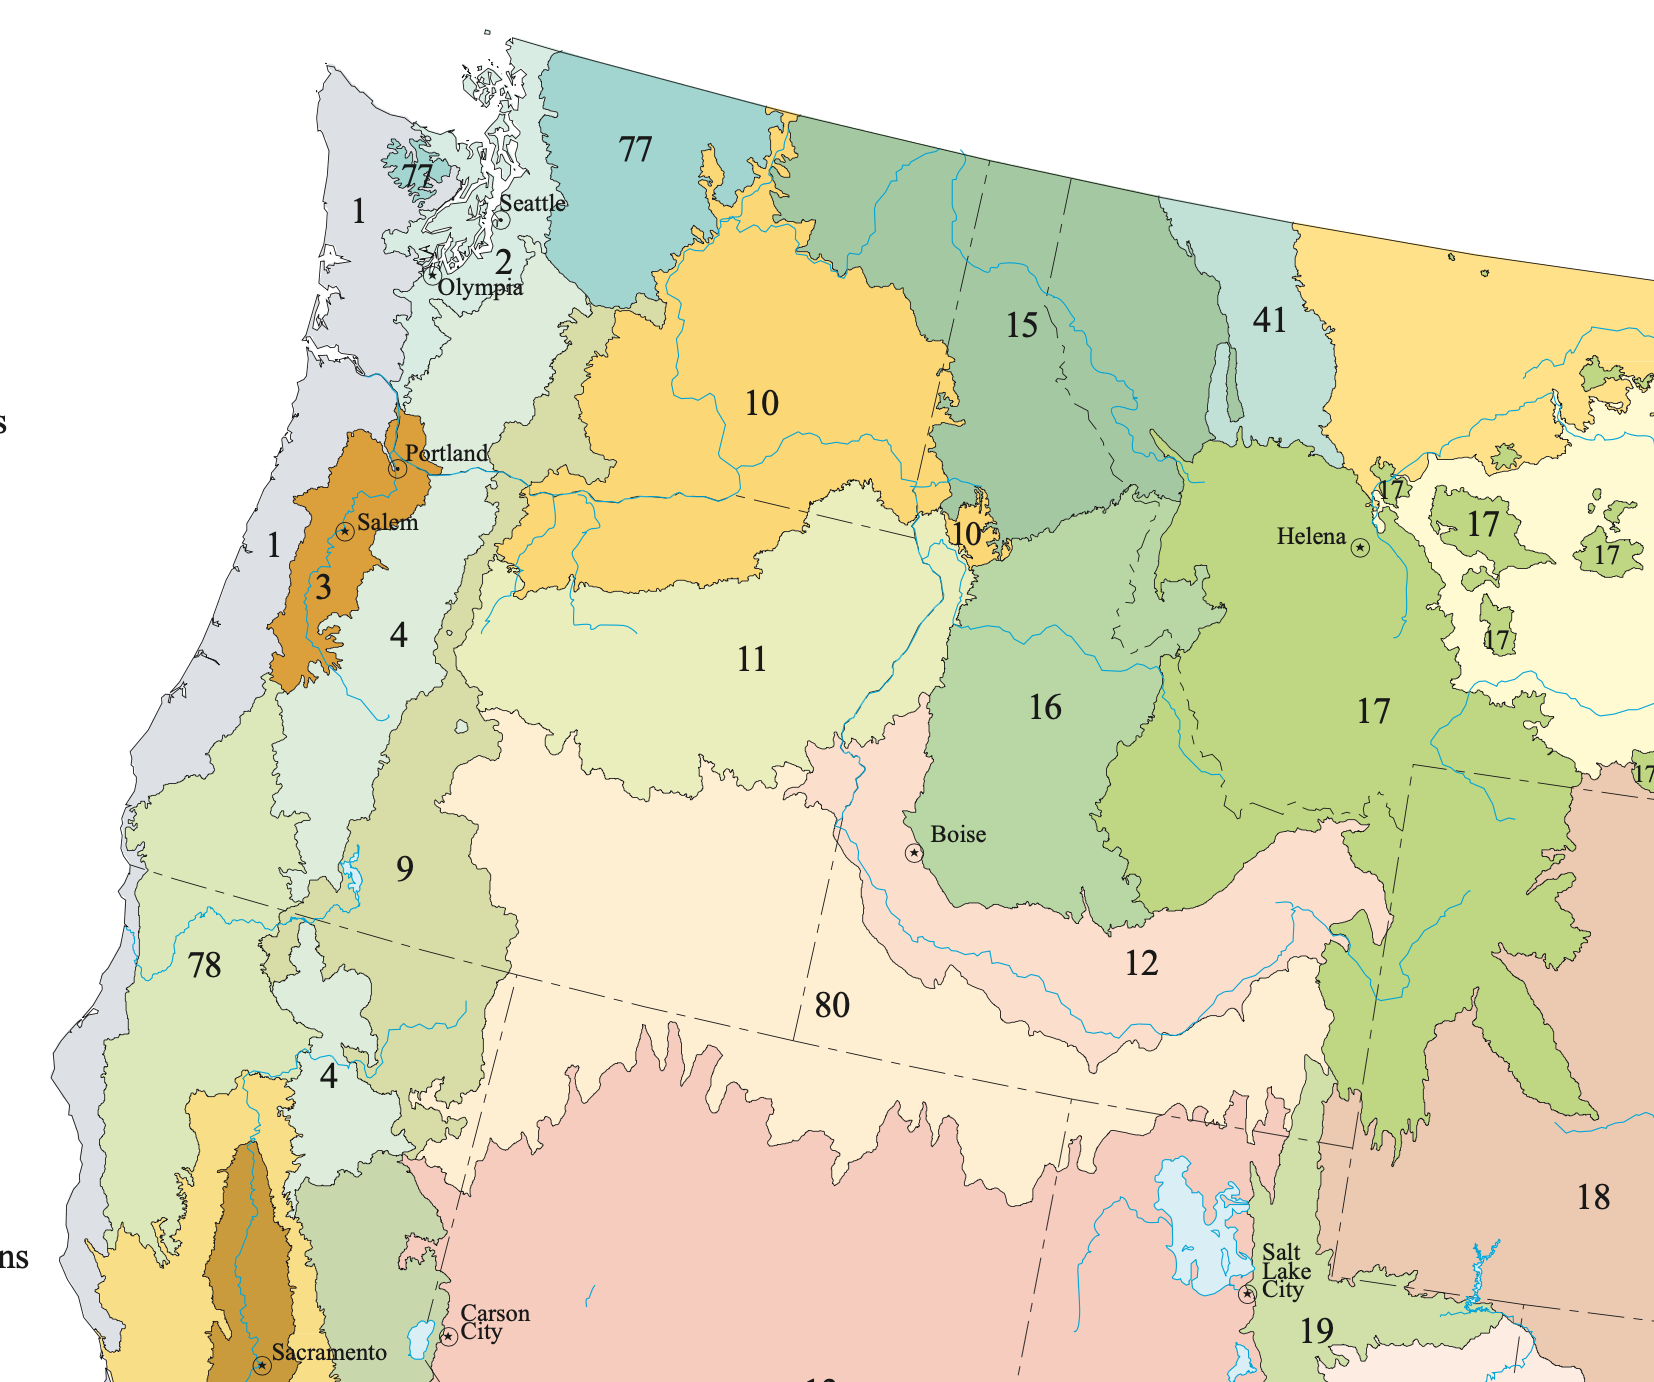

___________


In [ ]:
reduce_pdsi = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=5000, crs='EPSG:3310')

pdsi_stat_fc = ee.FeatureCollection(pdsi.map(reduce_pdsi)).filter(
    ee.Filter.notNull(pdsi.first().bandNames()))

The .getInfo() method transfers the data to this Colab notebook.
It will be in dictionary format.

In [ ]:
pdsi_dict = fc_to_dict(pdsi_stat_fc).getInfo()

Printing the first three lines of the dictionary

In [ ]:
print(type(pdsi_dict), '\n')
for prop in pdsi_dict.keys():
    print(prop + ':', pdsi_dict[prop][0:3] + ['...'])

<class 'dict'> 

millis: [286696800000, 287474400000, 288338400000, '...']
pdsi: [-0.11557088339094249, -0.071349305363176, 0.05588860987044778, '...']
system:index: ['19790201', '19790210', '19790220', '...']


Convert dict to pandas dataframe

In [ ]:
pdsi_df = pd.DataFrame(pdsi_dict)

In [ ]:
display(pdsi_df)
print(pdsi_df.dtypes)

,millis,pdsi,system:index
0,286696800000,-0.115571,19790201
1,287474400000,-0.071349,19790210
2,288338400000,0.055889,19790220
3,289116000000,0.253254,19790301
4,289893600000,0.274079,19790310
...,...,...,...
1483,1589090400000,-1.632519,20200510
1484,1589954400000,-1.502249,20200520
1485,1590991200000,-1.408271,20200601
1486,1591768800000,-1.237323,20200610


millis            int64
pdsi            float64
system:index     object
dtype: object


## Convert milliseconds to dates

In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

In [ ]:
pdsi_df = add_date_info(pdsi_df)
pdsi_df.head(5)

,millis,pdsi,system:index,Timestamp,Year,Month,Day,DOY
0,286696800000,-0.115571,19790201,1979-02-01 06:00:00,1979,2,1,32
1,287474400000,-0.071349,19790210,1979-02-10 06:00:00,1979,2,10,41
2,288338400000,0.055889,19790220,1979-02-20 06:00:00,1979,2,20,51
3,289116000000,0.253254,19790301,1979-03-01 06:00:00,1979,3,1,60
4,289893600000,0.274079,19790310,1979-03-10 06:00:00,1979,3,10,69


This stock function for grabbing dates is great, but to adapt it to my Payette dataset, I want the data in the form of "1987-01-01"


In [ ]:
pdsi_df['DATE'] = 0
for i in range(len(pdsi_df)):
  pdsi_df['DATE'][i] = str(pdsi_df['Timestamp'][i])[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
pdsi_df

,millis,pdsi,system:index,Timestamp,Year,Month,Day,DOY,DATE
0,286696800000,-0.115571,19790201,1979-02-01 06:00:00,1979,2,1,32,1979-02-01
1,287474400000,-0.071349,19790210,1979-02-10 06:00:00,1979,2,10,41,1979-02-10
2,288338400000,0.055889,19790220,1979-02-20 06:00:00,1979,2,20,51,1979-02-20
3,289116000000,0.253254,19790301,1979-03-01 06:00:00,1979,3,1,60,1979-03-01
4,289893600000,0.274079,19790310,1979-03-10 06:00:00,1979,3,10,69,1979-03-10
...,...,...,...,...,...,...,...,...,...
1483,1589090400000,-1.632519,20200510,2020-05-10 06:00:00,2020,5,10,131,2020-05-10
1484,1589954400000,-1.502249,20200520,2020-05-20 06:00:00,2020,5,20,141,2020-05-20
1485,1590991200000,-1.408271,20200601,2020-06-01 06:00:00,2020,6,1,153,2020-06-01
1486,1591768800000,-1.237323,20200610,2020-06-10 06:00:00,2020,6,10,162,2020-06-10


In [ ]:
## Drop unused columns

pdsi_df = pdsi_df.rename(columns={
    'pdsi': 'PDSI'
}).drop(columns=['millis', 'system:index', 'Year', 'Month', 'Day', 'Timestamp', 'DOY'])
pdsi_df.head(5)

,PDSI,DATE
0,-0.115571,1979-02-01
1,-0.071349,1979-02-10
2,0.055889,1979-02-20
3,0.253254,1979-03-01
4,0.274079,1979-03-10


In [ ]:
pdsi_df.dtypes

PDSI    float64
DATE     object
dtype: object

## Calculate NDVI
These steps are almost the exact same as before, but we're just importing a different ImageCollection under our Area of Interest

In [ ]:
ndvi = ee.ImageCollection('MODIS/006/MOD13A2').select('NDVI')

reduce_ndvi = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=1000, crs='EPSG:3310')

ndvi_stat_fc = ee.FeatureCollection(ndvi.map(reduce_ndvi)).filter(
    ee.Filter.notNull(ndvi.first().bandNames()))

In [ ]:
ndvi_dict = fc_to_dict(ndvi_stat_fc).getInfo()
ndvi_df = pd.DataFrame(ndvi_dict)
display(ndvi_df)
print(ndvi_df.dtypes)

,NDVI,millis,system:index
0,1574.658773,950832000000,2000_02_18
1,1716.179298,952214400000,2000_03_05
2,2198.271509,953596800000,2000_03_21
3,2639.828944,954979200000,2000_04_06
4,3537.889406,956361600000,2000_04_22
...,...,...,...
467,5637.046257,1591660800000,2020_06_09
468,5808.257163,1593043200000,2020_06_25
469,5795.834022,1594425600000,2020_07_11
470,5746.916841,1595808000000,2020_07_27


NDVI            float64
millis            int64
system:index     object
dtype: object


In [ ]:
ndvi_df['NDVI'] = ndvi_df['NDVI'] / 10000
ndvi_df = add_date_info(ndvi_df)
ndvi_df.head(5)

,NDVI,millis,system:index,Timestamp,Year,Month,Day,DOY
0,0.157466,950832000000,2000_02_18,2000-02-18,2000,2,18,49
1,0.171618,952214400000,2000_03_05,2000-03-05,2000,3,5,65
2,0.219827,953596800000,2000_03_21,2000-03-21,2000,3,21,81
3,0.263983,954979200000,2000_04_06,2000-04-06,2000,4,6,97
4,0.353789,956361600000,2000_04_22,2000-04-22,2000,4,22,113


In [ ]:
# run that same date parsing function on NDVI dataframe
ndvi_df['DATE'] = 0
for i in range(len(ndvi_df)):
  ndvi_df['DATE'][i] = str(ndvi_df['Timestamp'][i])[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
## Drop unused columns

ndvi_df = ndvi_df.drop(columns=['millis', 'system:index', 'Year', 'Month', 'Day', 'Timestamp', 'DOY'])
ndvi_df.head(5)

,NDVI,DATE
0,0.157466,2000-02-18
1,0.171618,2000-03-05
2,0.219827,2000-03-21
3,0.263983,2000-04-06
4,0.353789,2000-04-22


In [ ]:
ndvi_df

,NDVI,DATE
0,0.157466,2000-02-18
1,0.171618,2000-03-05
2,0.219827,2000-03-21
3,0.263983,2000-04-06
4,0.353789,2000-04-22
...,...,...
467,0.563705,2020-06-09
468,0.580826,2020-06-25
469,0.579583,2020-07-11
470,0.574692,2020-07-27


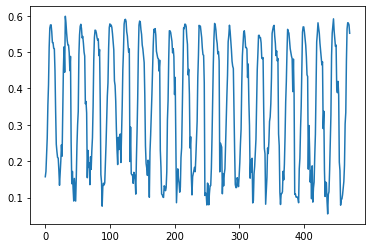

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ndvi_df['NDVI'])

## Merge the two dataframes together

In [ ]:
ndvi_df.dtypes
ndvi_df

,NDVI,DATE
0,0.157466,2000-02-18
1,0.171618,2000-03-05
2,0.219827,2000-03-21
3,0.263983,2000-04-06
4,0.353789,2000-04-22
...,...,...
467,0.563705,2020-06-09
468,0.580826,2020-06-25
469,0.579583,2020-07-11
470,0.574692,2020-07-27


In [ ]:
pdsi_df.dtypes
pdsi_df

,PDSI,DATE
0,-0.115571,1979-02-01
1,-0.071349,1979-02-10
2,0.055889,1979-02-20
3,0.253254,1979-03-01
4,0.274079,1979-03-10
...,...,...
1483,-1.632519,2020-05-10
1484,-1.502249,2020-05-20
1485,-1.408271,2020-06-01
1486,-1.237323,2020-06-10


In [ ]:
ndvi_pdsi_df = pd.merge(
    ndvi_df, pdsi_df, how='outer', on='DATE')

## Export a csv
To merge with my other csv in the Payette machine learning model

In [ ]:
ndvi_pdsi_df.to_csv("PDSI_NDVI_Payette.csv")